# NEU502B Homework 1: Unsupervised models of early vision
*Due February 14, 2024*

*Submission instructions:* First, rename your homework notebook to include your name (e.g. `homework-1-nastase.ipynb`); keep your homework notebook in the `homework` directory of your clone of the class repository. Prior to submitting, restart the kernel and run all cells (see *Kernel* > *Restart Kernel and Run All Cells...*) to make sure your code runs and the figures render properly. Only include cells with necessary code or answers; don't include extra cells used for troubleshooting. To submit, `git add`, `git commit`, and `git push` your homework to your fork of the class repository, then make a pull request on GitHub to sync your homework into the class repository.

The following homework assignment will explore unsupervised models of the early visual system. In the first section, we'll use principal component analysis (PCA) to capture natural visual images as a linear combination of latent basis vectors. In the second section, we'll use a more neurally-inspired model of Hebbian learning to recover similar structure. In the third section, we'll explore the functional topography of V1 using a competitive feature-based model of ocular dominance and orientation selectivity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Problem 1: Principal component analysis of natural scenes
Consider various attempts to formulate a theory about the function(s) of primary visual cortex (V1). Clearly V1 function cannot be entirely reduced to edge detection or Fourier decomposition, although it does perform a mixture of these functions. Simple cells are tuned to sine waveforms, yet broadly tuned to different spatial frequencies. A generative view of neural processing suggests that the early visual system may serve to identify the latent variables that generate visual stimuli (e.g. natural scenes).

The sparse coding model suggests to represent a multidimensional visual space as linear combinations of basis vectors, requiring the weights for the linear combinations to be sparse. Olshausen and Field ([1996](https://doi.org/10.1038/381607a0)) showed that these basis vectors turn out to resemble V1 receptive fields when derived from natural scenes. This method requires "over-completion"—i.e. a larger number of basis vectors than sensory space vectors. On the other hand, principal component analysis (PCA) aims to represent data with the fewest number of basis vectors possible. In this problem, we'll begin by finding the principal components (PCs) that account for the most local variance in natural images.

The visual system is composed of units with increasing receptive field sizes as information progresses up the visual hierarchy. We'll begin by loading in the natural scene images in `natural_images.npy`. Check the shape of the input data to orient yourself, then plot all 10 images.

In [2]:
# Load natural images array:
natural_images = np.load('natural_images.npy')

The shape of the scene images is (10, 512, 512)


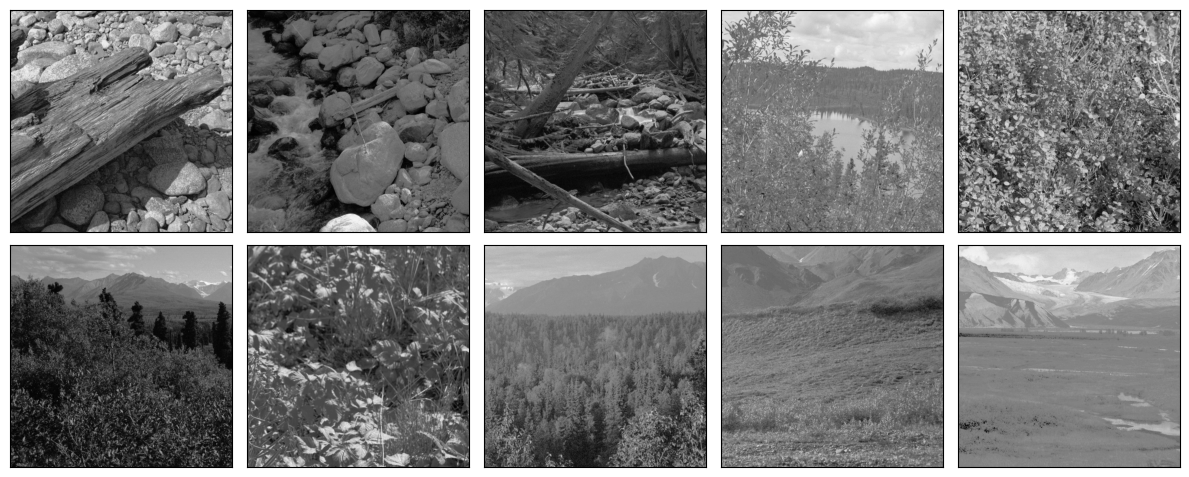

In [3]:
# Visualize the natural images:
print(f"The shape of the scene images is {natural_images.shape}")

## Plot all the images
fig, ax = plt.subplots(2, 5, figsize = (12, 5))

for i, ax in enumerate(ax.flatten()):
    ax.imshow(natural_images[i, :, :], cmap = "gray")
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])

plt.tight_layout()


Next, we'll use scikit-learn's [`PatchExtractor`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.PatchExtractor.html) to extract 1,000 local 12-pixels-by-12-pixel patches from each of the raw images, yielding 10,000 patches total. Organize the patches into a `(144, 10000)` array called `patches`.

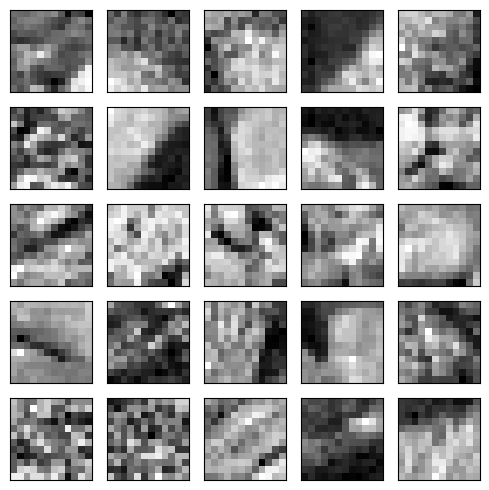

In [4]:
# Extract local patches from images 
from sklearn.feature_extraction.image import PatchExtractor

# Initialize sklearn extractor
extractor = PatchExtractor(patch_size=(12, 12), max_patches=1000)

# Use extractor to "transform" images (i.e. extract patches)
# and flatten 12 x 12 patches into shape (144, 10000):
data = extractor.transform(natural_images)
data = np.reshape(data, (len(data), -1)).T

## Plot 10 patches just to see what they look like
fig, ax = plt.subplots(5, 5, figsize = (5, 5))

for i, ax in enumerate(ax.flatten()):
    patch_i = np.reshape(data[:, i], (12, 12))
    ax.imshow(patch_i, cmap = "gray")
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])

plt.tight_layout()

Now, we'll run PCA on the array of sampled patches. First, de-mean (i.e. mean-center) each column of the array (i.e. along axis 0). Next, use `np.cov` to compute the sample covariance—this should result in a covariance matrix shaped `(144, 144)`. Finally, use `np.linalg.eigh` to compute the eigendecomposition of the covariance matrix. The eigenvectors are the principal components (PCs) and the eigenvalues quantify the variance explained by each corresponding eigenvector. Check the order of resulting eigenvalues; you may want to reverse the order of both the eigenvectors and eigenvalues to reflect most-to-least variance explained.

In [5]:
# Mean-center patches:
data_m = data - np.mean(data, axis = 0)

# Run PCA by computing covariance and applying eigendecomposition:
cov_mat = np.cov(data_m)
# print(cov_mat.shape)

eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
eigenvalues = eigenvalues[::-1]
eigenvectors = np.flip(eigenvectors)

Plot a "scree plot" of the eigenvalues from most to least variance explained across PCs (i.e. the eigenspectrum of the covariance matrix).

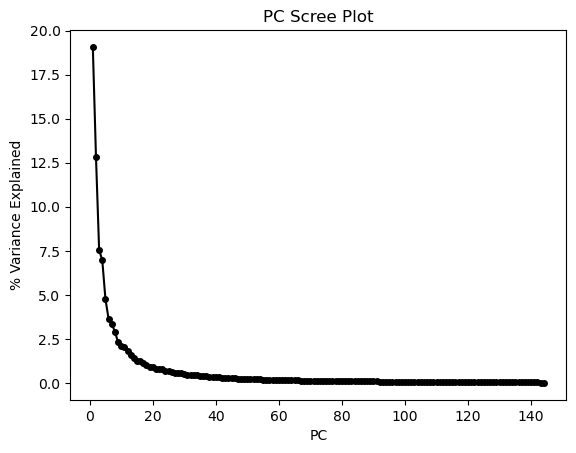

In [6]:
# Plot eigenvalues across PCs:

## make %variance explained
var_ratio = eigenvalues/np.sum(eigenvalues) * 100

n_PCs = len(eigenvalues)
x = np.arange(1, n_PCs + 1)

plt.plot(x, var_ratio, 'o-', c = 'k', markersize = 4)
plt.title("PC Scree Plot")
plt.xlabel("PC")
plt.ylabel("% Variance Explained")
plt.show()

Plot the first eight PCs as patches shaped `(12, 12)`. Consider how these relate to V1 receptive fields.

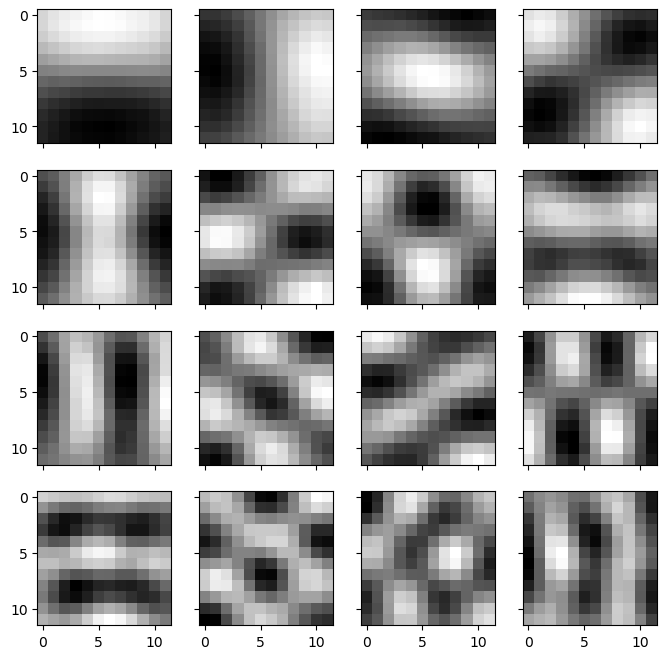

In [7]:
# Plot first eight PCs
fig, axs = plt.subplots(4, 4, figsize=(8, 8),
                        sharex=True, sharey=True)
for i, ax in enumerate(axs.ravel()):
    patch_pc = eigenvectors[:, i].reshape(12, 12)
    
    # Use matshow to plot each PC reshaped to (12, 12):
    ax.imshow(patch_pc, cmap = "gray")

Each PC is associated with an eigenvalue quantifying the amount of variance explained by that PC. Compute the cumulative proportion of variance explained from the eigenvalues and determine the number of PCs _k_ needed to explain .9, .95, .99, and .9999 of the variance, respectively.

In [8]:
# Compute cumulative proportion of variance explained:
cum_vaf = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Determine how many PCs are needed to account for 
# .9, .95, .99, and .9999 proportions of variance:
print(f'{np.min(np.where(cum_vaf > 0.9)) + 1} PCs are needed to explain 90% of the variance')
print(f'{np.min(np.where(cum_vaf > 0.95)) + 1} PCs are needed to explain 95% of the variance')
print(f'{np.min(np.where(cum_vaf > 0.99)) + 1} PCs are needed to explain 99% of the variance')
print(f'{np.min(np.where(cum_vaf > 0.9999)) + 1} PCs are needed to explain 99.99% of the variance')

43 PCs are needed to explain 90% of the variance
69 PCs are needed to explain 95% of the variance
116 PCs are needed to explain 99% of the variance
143 PCs are needed to explain 99.99% of the variance


Now, we'll reconstruct some of the original patches from the lower-dimensional PCs. For *k* = 1 and the four values of *k* determined in the previous cell, we'll project the original patches into the lower-dimensional space of the selected PCs, then try to reconstruct those patches from the lower-dimensional representation. If we select the top *k* PCs as columns of the eigenvector matrix $V$, we can perform this projection via the matrix multiplication $V V^T P$, where $V^T$ is the transpose of $V$ and $P$ is the matrix of (de-meaned) patches.

In [28]:
# For number of PCs k = 1 and the four values of k,
# use matrix multiplication to project the demeaned
# patches onto the k PCs and then reconstruct them
# from the low-dimensional space:
K = [1, np.min(np.where(cum_vaf > 0.9)), np.min(np.where(cum_vaf > 0.95)), np.min(np.where(cum_vaf > 0.99)), np.min(np.where(cum_vaf > 0.9999))]
recon_K = []

for k in K:
    V = eigenvectors[:, :k]
    recon_p = V @ V.T @ data_m
    recon_K.append(recon_p)

Plot a selection of five reconstructed patches for reduced space (*k* = 1 and the four values of *k* from above). For each selected patch, plot the original patch as well. Make sure the patches are shaped `(12, 12)`.

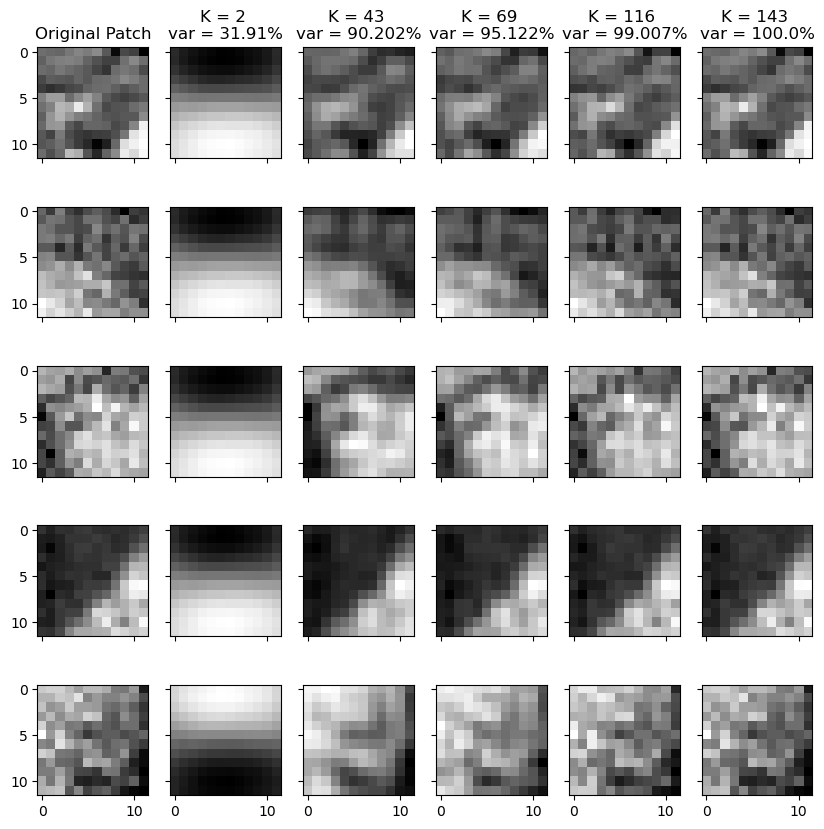

In [29]:
# Plot reconstructions at varying k and original:

fig, ax = plt.subplots(5, 6, figsize = (10, 10), sharex=True, sharey=True)

for patch_n in np.arange(5):
    ax[patch_n, 0].imshow(data_m[:,patch_n].reshape(12, 12), cmap = "gray") ## original patch 1
    
    if patch_n == 0:
        ax[patch_n, 0].set_title('Original Patch')
    
    for i, recon_k in enumerate(recon_K):
        patch_pc = recon_k[:, patch_n].reshape(12, 12)
        
        ax[patch_n,i+1].imshow(patch_pc, cmap = "gray")
        if patch_n == 0:
            ax[patch_n,i+1].set_title(f'K = {K[i] + 1} \nvar = {round(cum_vaf[K[i]] * 100, 3)}%')

### Problem 2: Hebbian learning

Let's start with this quote from Hebb (1949):

> "Let us assume that the persistence or repetition of a reverberatory activity (or "trace") tends to induce lasting cellular changes that add to its stability... When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing it, some growth process or metabolic change takes place in one or both cells such that A's efficiency, as one of the cells firing B, is increased."

Hebb was describing "spike-timing-dependent-plasticity", where the lags between pre- and post-synaptic neurons are responsible for long-term potentiation (LTP) or depression (LTD), depending on which fires first. (The story turns out to be not so simple, but...) The simplest learning rule following this description of plasticity takes the following form:

$$ (Eq. 1): \tau_w \frac{dw}{dt} = vu $$ 

<img src="weights.png" width="300">            

where $u$ is the input vector representing a pattern of activity (i.e. firing rate) across presynaptic elements, $w$ is the weight vector representing the synapse strength between pre- and postsynaptic neurons, and $v$ is a single postsynaptic output. The parameter $\tau_w$ controls the rate at which weights between pre- and postsynaptic elements change (i.e. the time required for a fractional change in the weights). The output of the postsynaptic element $v$ is given by:

$$ (Eq. 2): v = \vec{w} \cdot \vec{u} = \sum w_i u_i $$       

We need to modify the rule described in *Eq. 1*, which is unstable and does not capture competition between synapses. The instability comes from unbounded growth of the weight vector. To deal with this limitation, we will use a modified version of Hebb’s rule called Oja’s ([1982](https://doi.org/10.1007/BF00275687)) rule:

$$ (Eq. 3): \tau_w \frac{dw}{dt} =  v\vec{u} - \alpha v^2\vec{w} $$     

In *Eq. 3*, $\alpha$ is a positive constant controlling the "pull" from the multiplicative normalization term $v^2w$. This term limits the growth of the weight vector, mitigating one of the limitations of the basic rule. 

We'll train a feedforward Hebbian neural network with one output element and 144 input units (to match the size of the image patches from *Problem 1*) using Oja's rule. First, initialize a weight vector $w_i$ with random normal values at mean zero and variance $1e-4$. Set the parameters $\alpha = 10$ and $\tau_w = 2000$.

In [11]:
# Fix the random seed for consistent results
np.random.seed(1312)

# Randomly initialize input vector, alpha, and tau:
# n = np.random.randint(data_m.shape[1], size = data_m.shape[1]) ## pick random patches
u = data_m
w_i = np.random.normal(0, 0.0001, 144)
alpha = 10
tau = 2000

In the following, we define a function to train the network in batches of 500 random input patches, where each input patch is flattened into a 144-long vector. We compute the mean $dw⁄dt$ using Oja’s rule across all of the image patches in the batch (dividing by $\tau_w$) and add the mean $dw⁄dt$ to update $w$. Add brief comments to the following cell describing what each block of code below the comment is doing.

In [12]:
# Define function to train network in batches
def train(u, w, tau, alpha, batch_size=500):

    # Give each of the patches an id and permute them into batches to apply Oja's rule 
    n = u.shape[1]
    ids = np.arange(n)
    batches = np.random.permutation(ids).reshape(n // batch_size, batch_size)

    # Initialize a list to save each of the output updates
    # Start for loop for every batch
    updates = []
    for batch in batches:

        ## Grab the patches for this specific batch
        u_b = u[:, batch]

        # calculate the output of the post-sysnaptic element 
        v = np.dot(w, u_b)

        # Compute weight update using Oja's rule across all the image
        # patches in this batch
        dw = (v * u_b - alpha * (v ** 2)
              * np.repeat(w[:, np.newaxis], batch_size, axis=1)) / tau

        # Update w by adding the mean of dw and save each update in a list
        # for plotting below
        w += np.mean(dw, axis=1)
        updates.append(w.copy())

    return w, updates

In the following cell, write a loop to run the `train` function for at at least 250 epochs. Keep the updates to the weight vector across all epochs.

In [13]:
# Copy the randomly intialized weight vector
# to serve as input to the train function
ws = w_i.copy()

# Loop through 250+ training epoch and keep updates:
epoch = 500
save_w = []
save_updates = []

for i in np.arange(epoch):
    ws, updates = train(u, ws, tau, alpha)
    save_w.append(ws)
    save_updates.append(updates)

Now, we'll visualize how the magnitude of the weight vector changes across training iterations. Plot the norm of the weight vector $|w|^2$ at each update across all batches and epochs. Theoretically, we expect the magnitude of the weight vector to stabilize at $|w|^2  ≈  1⁄α$  as $\tau → ∞$ (here time corresponds to batches).

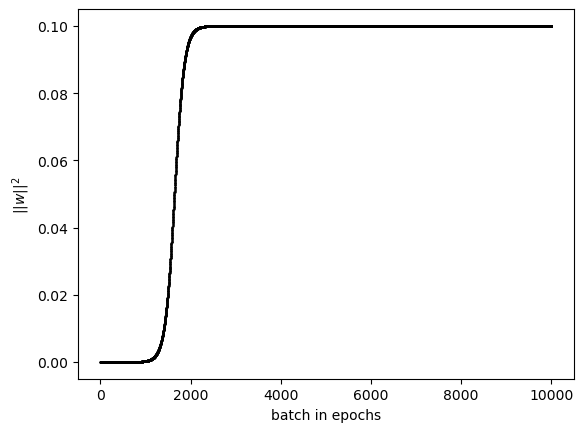

In [14]:
# Plot the weight magnitudes across batches:
save_updates = np.stack(save_updates)
x = np.arange(epoch * save_updates.shape[1])
save_updates_norm = [np.linalg.norm(save_updates[i, j, :])**2 for i in np.arange(epoch) for j in np.arange(save_updates.shape[1])]
plt.scatter(x, save_updates_norm, c = 'k', s = 0.5)
plt.xlabel("batch in epochs")
plt.ylabel(r'$||w||^2$')
plt.show()

Finally, visualize the weight vector learned by this single-output Hebbian network alongside the first principal component of the patches obtained in *Problem 1*. (Note that the polarity +/- of the PCs is arbitrary.)

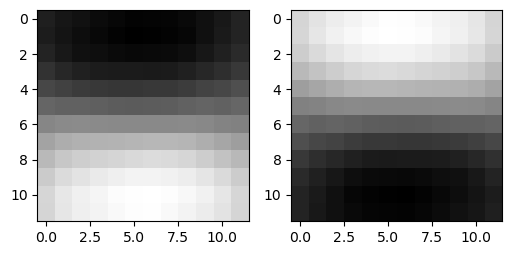

In [15]:
# Plot weight vector and first PC:
fig, ax = plt.subplots(1, 2, figsize = (6, 3))
save_w = np.array(save_w)
save_w_last = save_w[-1, :].reshape(12,12)
ax[0].imshow(save_w_last, cmap = "gray")
ax[1].imshow(recon_K[0][:, patch_n].reshape(12, 12), cmap = "gray")
plt.show()

What would happen if the network had multiple postsynaptic elements $v$, each fully connected to the input units? Consider that the update rules are local, so each output neuron only depends on the inputs and the associated weights. What modification could overcome the limitations of this implementation of Hebbian learning? (You don't have to implement anything here, just answer in words.)

When there are multiple fully connected postsynaptic elements, the network will be able to extract higher order PCs. This has be shown by the images above where we had the single-output network, the output looks similar to the first PC of the patches from Problem 1. The more output elements there are, the more PCs it will be able to extract, making the output look more similar to the original patch. 

One of the limitation of hebbian learning is similar to PCA where the process is constraint to be linear. When there is non-linearity in the data, it fails to extract those features. To overcome this, we can implement other non-linear methods, such as potentially adding more layers to the network.

### Problem 3: Ocular dominance and orientation selectivity

Inspection of V1 functional anatomy reveals alternative columns of cells that respond preferentially to input from the left and right eyes—referred to as ocular dominance columns. Hubel and Wiesel (e.g. [1977](https://doi.org/10.1098/rspb.1977.0085)) showed that subsets of cells in V1 are selective to different orientations of bars moving across their receptive fields. The proposed the "ice cube" model, where columns of iso-oriented cells span each cortical column of iso-ocular cells. In the following figure, the areas separated by black lines are the ocular dominance columns, while the gray lines denote iso-orientation contours. So-called "pinwheels" are the singularities where all orientations converge. These structures develop as the visual system receives inputs across the spectrum of these sensory features.<br><br>
    <img src="OD.png" width="600">

Similar maps can be obtained using competitive feature-based models adapted to capture ocular and orientation selectivity. One such models is the "elastic net" model ([Erwin et al., 1995](https://doi.org/10.1162/neco.1995.7.3.425)). Modeling cortical map formation with Hebbian models is highly complex, requiring consideration of retinotopic location, ocular dominance, and orientation preference simultaneously within the dynamics of the network. Competitive feature-based models provide a simpler framework to describe map development. These models characterize neurons and their inputs in terms of feature selectivity, unlike Hebbian models, which use synaptic weights. By the end of development, the receptive field of a cortical cell can be characterized by three values: ocularity, mean topographic location of inputs, and orientation selectivity.

In this exercise, we'll simulate the formation of cortical columns by implementing an elastic net model. In this modek, each cortical unit is represented by a five-dimensional vector $v_i = [x_i,y_i,o_i,e_i*cos(2θ_i ),e_i*sin(2θ_i )]$. Each element of the vector represents a feature: the $x$ and $y$ positions of the retinal location of the unit’s receptive field, the unit’s ocularity preference $o$, the orientation preference $θ$, and orientation preference strength $e$. Negative/positive values of ocularity correspond to left/right eye preference. We'll begin by generating a square 2D $N$ by $N$ cortical grid corresponding to the locations of $N^2$ cortical units in total. You may want to debug with e.g. $N=10$ for speed, but use $N=50$ for the final version.

In [16]:
# Square n x n cortical grid
N = 50
surf = np.zeros((N, N))

First, we'll construct an adjacency matrix $A$ for the 2D grid. The adjacency matrix is a square matrix that specifies whether two units in the 2D grid are neighbors or not. The adjacency matrix is shaped $N^2$ by $N^2$, where $N^2$ is the total number of units in the 2D grid. Units are neighbors if they are directly to the "north", "south", "east", or "west" of each other on the 2D grid. We'll use circular boundary conditions such that the units on the left side of the grid are neighbors with units on the right side of the grid. We'll also convert the adjacency matrix to a sparse matrix so our code runs faster.

In [17]:
from scipy.sparse import csr_matrix

# Define function to construct adjacency matrix
def adjacency(rows, cols):
    N = rows * cols
    A = np.zeros((N, N))
    for row in np.arange(rows):
        for col in np.arange(cols):
            i = row * cols + col
            if col > 0: 
                A[i - 1, i] = A[i, i - 1] = 1
            if row > 0: 
                A[i - cols, i] = A[i, i - cols] = 1
            if i == col: 
                A[i - rows, i] = A[i, i - rows] = 1
            if i == row * cols: 
                A[i - rows, i - 1] = A[i - 1, i - rows] = 1
    return csr_matrix(A)

Create a small adjacency matrix (e.g. for a $3$ by $3$ grid) and visualize it. To visualize a sparse array as a NumPy array, use the `.toarray()` method of the sparse array. Then create the full $A$ matrix using the function above.

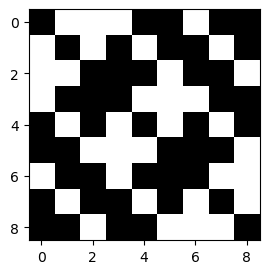

In [18]:
# Visualize a smaller example sparse array:
small_adj_mat = adjacency(3,3).toarray()
fig, ax = plt.subplots(figsize = (3,3))
plt.imshow(small_adj_mat, cmap = "gray")
plt.show()

In [19]:
# Create the full A matrix using the function above:
A = adjacency(N, N)

Next, we'll generate a matrix $V$ that contains the feature vectors for all cortical units, such that $V$ has $N^2$ rows and 5 columns. We'll set the first and second columns to be the $x$ and $y$ locations of the units on the 2D grid, respectively. Let $o_max=46.08$ and $e_max=61.44$. Initialize all $o_i=0$ (set the third column of $V$ equal to 0). Finally, for the 4th and 5th columns, set $e_i=0.01*e_max$, and $θ_i$ equally spaced between 0 and $pi$. 

In [20]:
# Build 5-dimensional feature vectors
V = np.zeros([N ** 2, 5])
V[:, 0] = np.concatenate([np.arange(N) for _ in np.arange(N)])
V[:, 1] = np.arange(N).repeat(N)
V[:, 2] = 0
V[:, 3] = 46.08 * 0.01 * np.cos(2 * np.linspace(0, np.pi, N ** 2))
V[:, 4] = 46.08 * 0.01 * np.sin(2 * np.linspace(0, np.pi, N ** 2))

Stimuli $u_i$ will be represented vectors with the same features as the cortical units such that $u_i = [x_i,y_i,o_i,e_i*cos(2θ_i ),e_i*sin(2θ_i )]$. Based on the cell above, generate 2,000,000 stimuli and store them as the rows of a matrix $U$. The stimulus values should be drawn randomly with uniform probability from the following ranges:

$$x, y \in [0, N-1]; o \in [-o_{max}, o_{min}]; e \in [0, e_{max}]; \theta \in [0, \pi]].$$ 

Remember to multiply 𝜃 by 2 before applying $cos$ and $sin$, for both stimuli and units.

In [21]:
# Fix the random seed for consistent results
np.random.seed(1312)

# Generate 2,000,000 random stimuli:
n_stim = 2000000
x = np.random.uniform(0, N-1, n_stim)
y = np.random.uniform(0, N-1, n_stim)
o = np.random.uniform(-46.08, 46.08, n_stim)
theta = np.random.uniform(0,np.pi, n_stim)
e = np.random.uniform(0, 61.44, n_stim)

U = np.column_stack([x, y, o, e*np.cos(2*theta), e * np.sin(2*theta)]) ## 2000000 x 5

For each stimulus, we'll update the feature selectivity matrix $V$ using the following equations. First, compute a vector of $N^2$ weights:

 $$w=[(w_1, …, w_{N^2})].T$$
 
 $$ w_j = \frac{f \left(u_iv_j \sigma \right)}{\sum_k f \left( u_iv_k\sigma \right)} $$
 
 $$ f \left( u,v,\sigma \right) = \text{exp} \left( \frac{-| u-v_i |^2}{2 \sigma^2} \right)  $$ where $|u-v|$ is the Euclidean distance between $u$ and $v$, $σ = 2.771$, and each weight is normalized by the sum of the rest of the weights. Next, update the cortical unit values with:
 
 $$ V_{i+1} = V_i + \alpha w \cdot (u_i - V_i) + \beta \sum_{neighbors in loc=(N,E,W,S)} V^{loc}_i - V_i  $$
 $$ V_{i+1} = V_i + \alpha w \cdot (u_i - V_i) + \beta (A V_i - 4 V_i)$$
 
 where $\alpha=0.4$ and $\beta=0.0001$, and $V_i$ are the values of the cortical units at time $i$. The neighbors $V^{loc}_i$ are the neighbors of each cortical unit $v_i$, which fill the rows of $V^{loc}$. However, we can more efficiently compute the summation using the adjacency matrix $A$ as shown in the second line of the above equation, which alleviates the need to compute $V^loc$.

In the above equation, $(u_i-V_i )$ means that the current stimulus vector $u_i$ is subtracted from each row of $V_i$. Next, the notation $w .*(u_i-V_i)$ means multiply each column of $(u_i-V_i )$ element-wise by the vector $w$. Both operations in $w .*(u_i-V_i )$ can be accomplished via array broadcasting.
 
In summary, in this model the cortical unit activities are changed by two terms. In the first, the units are updated by their difference from the input $u_i$, with the weight vector $w$ serving as a normalizing force. The second term promotes units having similar selectivity to their neighbors. In the model, $\alpha$ and $\beta$ control the tradeoff between these two terms, and $\sigma$ controls the effective range (distance) between an input and the cortical neurons. If implemented as described, the simulation can take around 10–20 minutes (you may need to `conda install tqdm` to implement a progress bar).

In [22]:
from scipy.spatial.distance import cdist

# Compute weight vector
def weights(u, V, sigma=2.771):
    dists = cdist(u.reshape(1, 5), V)
    w = np.exp(-dists ** 2 / (2 * sigma ** 2))
    return w.T / w.sum()

# Update feature matrix V
def update_V(u, V, A, alpha=0.4, beta=0.0001):
    w = weights(u, V)
    return V + alpha * w * (u - V) + beta * (A @ V - 4 * V)

In [23]:
from os.path import exists
from tqdm import tqdm

# Fit the model and save
if not exists('V.npy'):
    for i in tqdm(range(0, n_stim)):
        V = update_V(U[i, :], V, A)
    np.save('V.npy', V)
else:
    V = np.load('V.npy')

After the fitting procedure finishes, plot the resulting 2D cortical map. First, threshold the ocularity above and below zero, such that values above zero are 1 and values below zero are -1. Plot the filled contours of ocularity using the `contourf()` function from `matplotlib`. Next, compute the orientation selectivity preference for each unit and plot contour lines of iso-orientation using the `countour()` function. Plot enough lines such that the contour lines represent changes of 15 degrees. Plot the ocularity map, the orientation map, and an overlaid visualization of both maps. These plots require mapping the values in the matrix $V$ back to the original $N$ by $N$ 2D locations of the units (we've included some hints below).

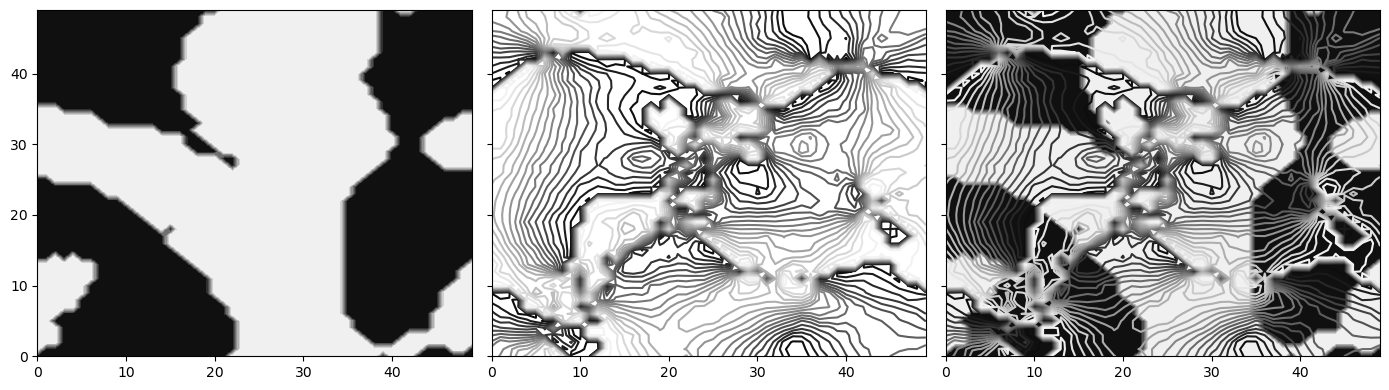

In [25]:
# Plot the cortical map with contours
V_plot = V.copy()
x,y = np.meshgrid(np.arange(N), np.arange(N))
fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True, sharey=True)

# Binarize the ocularity features:
ocu = V[:,2]
ocu[ocu > 0] = 1
ocu[ocu < 0] = -1

# Plot the ocular dominance with contourf:
axs[0].contourf(ocu.reshape(N,N), cmap = "gray")

# Convert the orientation feature to theta
theta = np.arctan(V_plot[:, 4] / V_plot[:, 3]) * 180 / np.pi

# Plot the orientation tuning with contour:
levels = np.linspace(theta.min(), theta.max(), 20)
axs[1].contour(theta.reshape(N,N), cmap='gray', levels=levels)

# Overlay combined ocularity and orientation maps:
axs[2].contourf(ocu.reshape(N,N), cmap = "gray")
axs[2].contour(theta.reshape(N,N), cmap='gray', levels=levels)

plt.show()

Given the "developmental" organization of this cortical topography, what do you think would happen in a deprivation experiment where the inputs from one eye are dramatically impaired? (You don't have to implement anything here, just answer in words.)

When inputs from one eye is dramatically impaired, the representation of the other eye in the cortex will dramatically increase to compensate. In the occularity image above, there will be either less white or black patches depending on which eye is impaired while the area representing the other eye will increase. 

#### References

* Erwin, E., Obermayer, K., & Schulten, K. (1995). Models of orientation and ocular dominance columns in the visual cortex: a critical comparison. *Neural Computation*, *7*(3), 425–468. https://doi.org/10.1162/neco.1995.7.3.425

* Hebb, D. O. (1949). *The Organization of Behavior: A Neuropsychological Theory*. John Wiley & Sons.

* Hubel, D. H., & Wiesel, T. N. (1977). Ferrier lecture - Functional architecture of macaque monkey visual cortex. *Proceedings of the Royal Society of London Series B: Biological Sciences*, *198*(1130), 1–59. https://doi.org/10.1098/rspb.1977.0085

* Oja, E. (1982). Simplified neuron model as a principal component analyzer. *Journal of Mathematical Biology*, *15*, 267–273. https://doi.org/10.1007/BF00275687

* Olshausen, B. A., & Field, D. J. (1996). Emergence of simple-cell receptive field properties by learning a sparse code for natural images. *Nature*, *381*(6583), 607–609. https://doi.org/10.1038/381607a0